In [1]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, EigenGradCAM,LayerCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from ssl_byol import model
import torch
from loader import ImagesDataset
import sys
from evaluate import img_pipe
sys.path.append('../liver-canser-prediction')
from src.preprocess.dataset import padding_and_resize
import cv2
from matplotlib import pyplot as plt
import numpy as np
from model import cls
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from evaluate import img_pipe
import numpy as np
import os

{'T1 HB': [[0.2962, 0.2962, 0.2962], [0.2527, 0.2527, 0.2527]], 'T2': [[0.2055, 0.2055, 0.2055], [0.1727, 0.1727, 0.1727]], 'out': [[0.2, 0.2, 0.2], [0.1644, 0.1644, 0.1644]]}
Loaded pretrained weights for efficientnet-b2


In [2]:
# EigenCAM,  _conv_head, 85_0.78
# GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, EigenGradCAM, LayerCAM
ds = ImagesDataset()
target_category = 1

138 images found


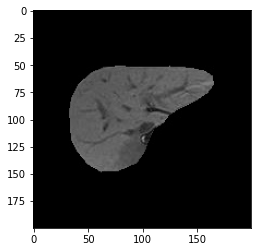

In [3]:
im = cv2.imread('/home/rockyo/liver-canser-prediction/data/segmented_liver/pT2 HCC/out/26180159.jpg')
im = padding_and_resize(im)
plt.imshow(im)
plt.show()


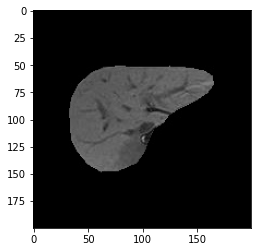

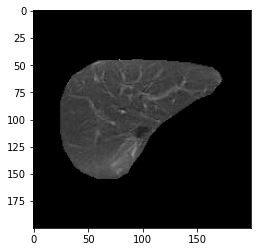

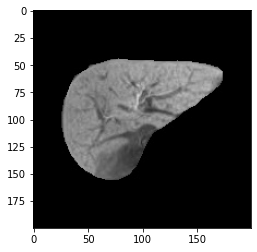

In [4]:
i=134
f = ds.__getitem__(i)
# assert(os.path.isfile(f.replace('mri_type', 'out')+'.jpg'))
im = cv2.imread(f.replace('mri_type', 'out') + '.jpg')
im = padding_and_resize(im)
plt.imshow(im)
plt.show()

im = cv2.imread(f.replace('mri_type', 'T2') + '.jpg')
im = padding_and_resize(im)
plt.imshow(im)
plt.show()

im = cv2.imread(f.replace('mri_type', 'T1 HB') + '.jpg')
im = padding_and_resize(im)
plt.imshow(im)
plt.show()

In [5]:
from torchvision import transforms as T
from evaluate import ImgPad
from PIL import Image
def img_process(f):
    image_size = 200
    preprocess = T.Compose([     
        T.ToTensor(),
        ImgPad(image_size),  
        T.Resize((image_size, image_size)),
    ])
    img = Image.open(f +'.jpg')
    img = preprocess(img).numpy()
    img = np.moveaxis(img, 0, -1)
    return img
def show_cam(f, model_cam, target_layer, t):
    cam = LayerCAM(model=model_cam, target_layer=target_layer, use_cuda=True)
#     img1 = img_pipe(f.replace('mri_type', 'out') + '.jpg', 'out', mode="eval")
#     img2 = img_pipe(f.replace('mri_type', 'T2') + '.jpg', 'T2', mode="eval")
#     img3 = img_pipe(f.replace('mri_type', 'T1 HB') + '.jpg', 'T1 HB', mode="eval")
    imgs = img_pipe(f.replace('mri_type', t) + '.jpg', t, mode="eval")
#     imgs = torch.stack([img1, img2, img3])
    print(imgs.shape)
    grayscale_cam = cam(input_tensor=imgs.unsqueeze(0),
        target_category=1,
#         aug_smooth=True,
        eigen_smooth=True
    )
    return grayscale_cam

torch.Size([3, 200, 200])


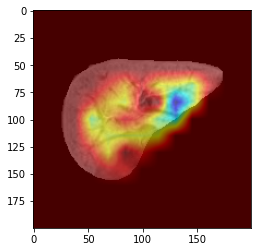

In [52]:
m = cls(class_weight=[0.78409091, 1.38], enc='single')
# m = model.learner


ff = '/home/rockyo/byol/model_t1/0.82_0.77.pth'
m.load_state_dict(torch.load(ff))
m.eval()
model_cam = m.encoder.encoder.net
target_layer = model_cam._blocks[11]


# %matplotlib inline
for i, t in enumerate([
#      'out', 
#     'T2',
    'T1 HB'
]):
    g = show_cam(f, model_cam, target_layer, t)[0]
   
    im = img_process(f.replace('mri_type', t))
    v = show_cam_on_image(im, g)
    plt.imshow(v)
    plt.show()